# Inserting a DLA realistically [v1.1]

In [1]:
%matplotlib notebook

In [2]:
# imports
from linetools.spectra.xspectrum1d import XSpectrum1D

from specdb.specdb import IgmSpec

from pyigm.abssys.dla import DLASystem
from pyigm.surveys.dlasurvey import DLASurvey

sys.path.append(os.path.abspath("../../src"))
import training_set as tset

## Load SDSS

In [3]:
sdss = DLASurvey.load_SDSS_DR5(sample='all')

SDSS-DR5: Loading DLA file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_alldla.fits.gz
SDSS-DR5: Loading QSOs file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_dlagz_s2n4.fits


In [4]:
igmsp = IgmSpec()

Using /u/xavier/local/Python/igmspec/DB/IGMspec_DB_v02.hdf5 for the catalog file
Using /u/xavier/local/Python/igmspec/DB/IGMspec_DB_v02.hdf5 for the DB file
Available surveys: [u'BOSS_DR12', u'HSTQSO', u'SDSS_DR7', u'KODIAQ_DR1', u'MUSoDLA', u'HD-LLS_DR1', u'2QZ', u'ESI_DLA', u'HDLA100', u'GGG', u'COS-Halos', u'HST_z2', u'COS-Dwarfs', u'XQ-100']
Database is igmspec
Created on 2016-Oct-25


## Grab the sightlines

In [5]:
slines, sdict = tset.grab_sightlines(sdss)

We have 5034 sightlines for analysis
Min z = 2.23244, Median z = 2.65984, Max z = 5.19597


In [6]:
slines[0:3]

PLATE,FIB,RA,DEC,FLG_BAL,IQSO,MAG,S2N,Z_START,Z_END,ZEM,DX
,,deg,deg,,,,,,,,
int32,int32,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64
266,92,146.22601,-0.72509875,0,4,19.0820007324,8.54980564117,2.20000004768,2.25759506226,2.29049992561,0.184012498912
270,254,152.23239,-0.97123272,0,9,19.0230007172,7.49763822556,2.30636157714,3.0556242466,3.09659004211,2.56581152274
271,391,154.14992,0.14750838,0,16,18.0650005341,18.982629776,2.20000004768,2.25551605225,2.28839993477,0.177634457341


## Try one at z~3

### Pick the sightline

In [7]:
i3 = np.argmin(np.abs(slines['ZEM']-3.))
s3 = slines[i3]

In [8]:
spec3, meta = igmsp.spec_from_coord((s3['RA'], s3['DEC']), isurvey=['SDSS_DR7'])

Your search yielded 1 match[es]
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


/Users/xavier/local/Python/linetools/linetools/spectra/xspectrum1d.py:248: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


### Fake DLA

In [9]:
dla = DLASystem((s3['RA'],s3['DEC']), 2.8, (None,None),21.0)
dla

<DLASystem: 09:51:07.1712 35:22:55.4196, 2.8, NHI=21, Z/H=0>

### Model

In [10]:
vmodel, _ = dla.model_abs(spec3[0], fwhm=3)

/Users/xavier/local/Python/pyigm/pyigm/abssys/utils.py:151: UserWarning: Generating the absorption lines from the system info, not abslines
  warnings.warn("Generating the absorption lines from the system info, not abslines")
/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:181: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:182: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')


Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


/Users/xavier/local/Python/linetools/linetools/analysis/voigt.py:220: UserWarning: Rebinned tau back to your input array.  Reconsider input
  warnings.warn('Rebinned tau back to your input array.  Reconsider input')
/Users/xavier/local/Python/pyigm/pyigm/abssys/utils.py:189: RuntimeWarning: overflow encountered in exp
  flux = np.exp(-1*tau_tot)


<IPython.core.display.Javascript object>


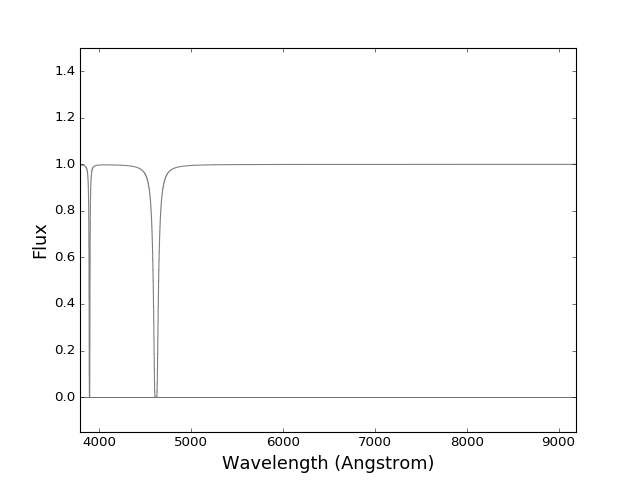

In [11]:
vmodel.plot()

### Apply to spectrum
    The core is noiseless...

In [12]:
new_spec3 = XSpectrum1D.from_tuple((vmodel.wavelength, vmodel.flux.value*spec3[0].flux.value, spec3[0].sig))

<IPython.core.display.Javascript object>


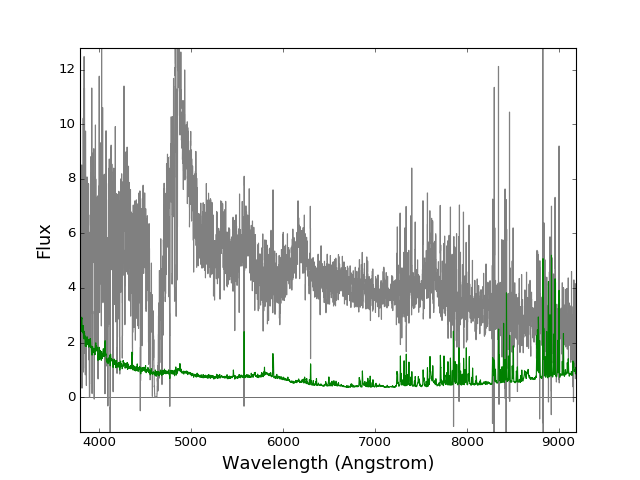

In [13]:
new_spec3.plot()

### Add noise
    Add noise scaled by 1-flux

In [14]:
rstate=np.random.RandomState()

In [15]:
rand = rstate.randn(new_spec3.npix)

In [16]:
noise = rand * new_spec3.sig * (1-vmodel.flux.value)

In [18]:
final_spec = XSpectrum1D.from_tuple((vmodel.wavelength, new_spec3.flux.value+noise, spec3[0].sig))

<IPython.core.display.Javascript object>


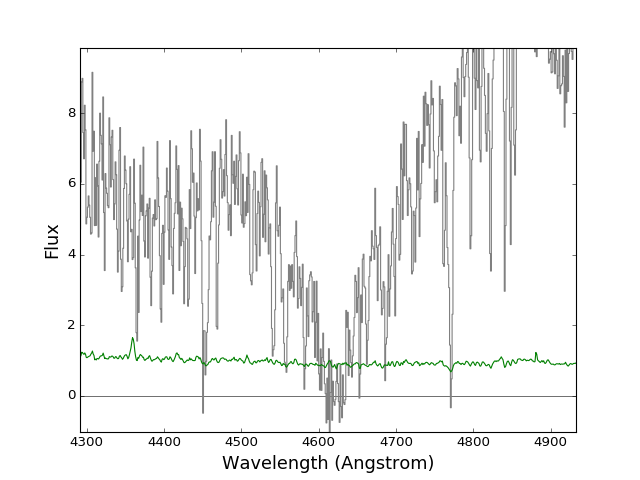

In [19]:
final_spec.plot()